# Figure 4 in main paper of O2 consumption by NOB in AMZ

imports

In [2]:
import sys
print("python version =",sys.version[:5])

import os
import numpy as np
import xarray as xr
import netCDF4 as nc
import pandas as pd
import dask as dsk
from dask.diagnostics import ProgressBar

# plotting packages
import matplotlib as mpl
import seaborn as sb
sb.set(style='ticks')
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
from cmocean.tools import lighten

# others
import scipy as sc
from scipy.interpolate import interp1d

print("numpy version =", np.__version__)
print("xarray version =", xr.__version__)
print("netCDF4 version =", nc.__version__)
print("dask version =", dsk.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sc.__version__)
print("seaborn version =", sb.__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)

wrkdir = "/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg"
os.chdir(wrkdir)
os.getcwd()

#ProgressBar().register()


python version = 3.10.
numpy version = 1.26.4
xarray version = 2024.3.0
netCDF4 version = 1.6.5
dask version = 2023.3.0
pandas version = 2.2.2
scipy version = 1.14.1
seaborn version = 0.12.2
matplotlib version = 3.7.1
cartopy version = 0.23.0
cmocean version = v3.0.3


'/expanse/lustre/projects/ciw112/pbuchanan/data/peru_chile_0p1/avg'

Load model output

In [3]:
data = xr.open_mfdataset(['2hets_def/avg_2050_D000-D090.nc','2hets_def/avg_2050_D091-D180.nc','2hets_def/avg_2050_D181-D270.nc', '2hets_def/avg_2050_D271-D365.nc'])
norm_o2cons = data["O2_CONSUMPTION"]
norm_nitrox = data["NITROX"]
norm_ammox = data["AMMOX"]
#norm_nob = data["NOB"].where(data["NOB"] > 0.0, other=0.0)
norm_hz = data["Hz"]
norm_zr = data["z_r"]
norm_o2 = data["O2"]



/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value enc

Get Coordinates

In [4]:
fname = '/home/pbuchanan/peru_chile_0p1_files/peru_chile_0p1_grd.nc' 
data = xr.open_dataset(fname)
data = data.rename_dims({"eta_rho":"y_c", "xi_rho":"x_c"})
lon_rho = data.coords['lon_rho']
lat_rho = data.coords['lat_rho']

pn = data['pm']
pm = data['pn']
area = 1.0/(pn*pm)



Define a new dataset manually with its coordinates and the variables we want

In [5]:

chunky = {'time':1, 'z_c':1, 'y_c':502, 'x_c':402}
ds = xr.Dataset(
    {"lon_rho": ( ("y_c", "x_c"), lon_rho.values),
     "lat_rho": ( ("y_c", "x_c"), lat_rho.values),
     "area":    ( ("y_c", "x_c"), area.values),
     "norm_Hz": ( ("time", "z_c", "y_c", "x_c"), norm_hz.values),
     },
    coords={"x_c": (["x_c"], np.arange(1,403)),
            "y_c": (["y_c"], np.arange(1,503)),
            "z_c": (["z_c"], np.arange(1,43)),
            "time":(["time"],np.arange(1,366))}).chunk(chunks=chunky)

# check size of the arrays in Gb and their chunks in Mb
print("Total size of array in Gb", ds.nbytes * 1e-9)
print("Total size of chunk in Mb", ds.sel(time=1).nbytes * 1e-6)



Total size of array in Gb 12.377053416
Total size of chunk in Mb 36.332296


/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/scratch/pbuchanan/job_33983122/miniconda3/envs/df-parallel/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value enc

In [6]:
### assign other variables to the dataset
ds = ds.assign({"norm_zr": ( ("time", "z_c", "y_c", "x_c"), norm_zr.values)}).chunk(chunks=chunky)
print("Added z_rho")
ds = ds.assign({"norm_O2": ( ("time", "z_c", "y_c", "x_c"),  norm_o2.values)}).chunk(chunks=chunky)
print("Added O2")
ds = ds.assign({"norm_ammox": ( ("time", "z_c", "y_c", "x_c"), norm_ammox.values)}).chunk(chunks=chunky)
print("Added ammox")
ds = ds.assign({"norm_nitrox": ( ("time", "z_c", "y_c", "x_c"), norm_nitrox.values)}).chunk(chunks=chunky)
print("Added nitrox")
ds = ds.assign({"norm_o2cons": ( ("time", "z_c", "y_c", "x_c"), norm_o2cons.values)}).chunk(chunks=chunky)
print("Added o2cons")

ds

Added z_rho
Added O2
Added ammox
Added nitrox
Added o2cons


<xarray.Dataset> Size: 74GB
Dimensions:      (y_c: 502, x_c: 402, time: 365, z_c: 42)
Coordinates:
  * x_c          (x_c) int64 3kB 1 2 3 4 5 6 7 8 ... 396 397 398 399 400 401 402
  * y_c          (y_c) int64 4kB 1 2 3 4 5 6 7 8 ... 496 497 498 499 500 501 502
  * z_c          (z_c) int64 336B 1 2 3 4 5 6 7 8 9 ... 35 36 37 38 39 40 41 42
  * time         (time) int64 3kB 1 2 3 4 5 6 7 ... 359 360 361 362 363 364 365
Data variables:
    lon_rho      (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    lat_rho      (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    area         (y_c, x_c) float32 807kB dask.array<chunksize=(502, 402), meta=np.ndarray>
    norm_Hz      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_zr      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_O2      (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_ammox   (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_nitrox  (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>
    norm_o2cons  (time, z_c, y_c, x_c) float32 12GB dask.array<chunksize=(1, 1, 502, 402), meta=np.ndarray>

Check the size of the arrays in Gb and their chunks in Mb

In [8]:
print("Total size of array in Gb", ds.nbytes * 1e-9)
print("Total size of chunk in Mb", ds.sel(time=1).nbytes * 1e-6)


Total size of array in Gb 74.25015981600001
Total size of chunk in Mb 205.847656


Calculate the rates of O2 consumption and other processes within the AMZ and over whole area

In [9]:
#%% calculate the rates of O2 consumption over the whole area and within the AMZ (O2 < 1 µM)

nitrox = ds['norm_nitrox'] * ds['norm_Hz'] * ds['area']
o2cons = ds['norm_o2cons'] * ds['norm_Hz'] * ds['area']
ammox = ds['norm_ammox'] * ds['norm_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100

print(" ")
print("Annual mean loss of O2 within All (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within All (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within All (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within All due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within All due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within All", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within All", o2aoa_sum.mean().values)

amz_threshold = 1.0

nitrox = ds['norm_nitrox'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
o2cons = ds['norm_o2cons'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']
ammox = ds['norm_ammox'].where(ds['norm_O2'] < amz_threshold, other=0.0) * ds['norm_Hz'] * ds['area']

nitrox_sum = nitrox.sum(dim=["z_c","y_c","x_c"])
o2cons_sum = o2cons.sum(dim=["z_c","y_c","x_c"])
ammox_sum = ammox.sum(dim=["z_c","y_c","x_c"])

o2nob_sum = nitrox_sum * 12.9/27.8 / o2cons_sum * 100
o2aoa_sum = ammox_sum * 15.5/11.0 / o2cons_sum * 100

print(" ")
print(" ")
print(" ")
print("Annual mean loss of O2 within AMZ (Tmol O2)", o2cons_sum.mean().values*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2)", ammox_sum.mean().values*14*1e-3*1e-12*86400*365)
print("Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2)", nitrox_sum.mean().values*14*1e-3*1e-12*86400*365)
print(" ")
print("Annual mean loss of O2 within AMZ due to NOB (Tmol O2)", nitrox_sum.mean().values*1e-3*1e-12*86400*365*12.9/27.8)
print("Annual mean loss of O2 within AMZ due to AOA (Tmol O2)", ammox_sum.mean().values*1e-3*1e-12*86400*365*15.5/11.0)
print(" ")
print("Annual % contribution of NOB to O2 consumption within AMZ", o2nob_sum.mean().values)
print("Annual % contribution of AOA to O2 consumption within AMZ", o2aoa_sum.mean().values)



 
Annual mean loss of O2 within All (Tmol O2) 277.186831515648
Annual mean oxidation of NH4-->NO2 within All (Tg NO2) 212.76935337369596
Annual mean oxidation of NO2-->NO3 within All (Tg NO2) 219.65078306304
 
Annual mean loss of O2 within All due to NOB (Tmol O2) 7.280306016221008
Annual mean loss of O2 within All due to AOA (Tmol O2) 21.415097255144726
 
Annual % contribution of NOB to O2 consumption within All 2.652864
Annual % contribution of AOA to O2 consumption within All 7.797087
 
 
 
Annual mean loss of O2 within AMZ (Tmol O2) 1.0291234334400001
Annual mean oxidation of NH4-->NO2 within AMZ (Tg NO2) 0.91989952236
Annual mean oxidation of NO2-->NO3 within AMZ (Tg NO2) 13.161360510144002
 
Annual mean loss of O2 within AMZ due to NOB (Tmol O2) 0.4362321443495827
Annual mean loss of O2 within AMZ due to AOA (Tmol O2) 0.09258728958818184
 
Annual % contribution of NOB to O2 consumption within AMZ 42.661415
Annual % contribution of AOA to O2 consumption within AMZ 8.937943


See if we can back out the integrated contribution of NOB to O2 consumption by weighting a calculation of the mean by the total O2 consumption rate

# make figure of obs versus model spread

In [11]:
## read in the model data in case you don't want to wait for the above calculation to finish
dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_spatialstatistics.xlsx", engine='openpyxl')

amz_threshold = dat['O2_bound']
norm_o2cons_amz_01 = dat['o2cons_1st_percentile']
norm_o2cons_amz_05 = dat['o2cons_5th_percentile']
norm_o2cons_amz_12 = dat['o2cons_12th_percentile']
norm_o2cons_amz_25 = dat['o2cons_25th_percentile']
norm_o2cons_amz_50 = dat['o2cons_50th_percentile']
norm_o2cons_amz_75 = dat['o2cons_75th_percentile']
norm_o2cons_amz_88 = dat['o2cons_88th_percentile']
norm_o2cons_amz_95 = dat['o2cons_95th_percentile']
norm_o2cons_amz_99 = dat['o2cons_99th_percentile']
norm_o2cons_amx_me = dat['o2cons_mean']
norm_o2cons_amx_wm = dat['o2cons_weightedmean']

norm_o2nob_amz_01 = dat['o2nob_1st_percentile']
norm_o2nob_amz_05 = dat['o2nob_5th_percentile']
norm_o2nob_amz_12 = dat['o2nob_12th_percentile']
norm_o2nob_amz_25 = dat['o2nob_25th_percentile']
norm_o2nob_amz_50 = dat['o2nob_50th_percentile']
norm_o2nob_amz_75 = dat['o2nob_75th_percentile']
norm_o2nob_amz_88 = dat['o2nob_88th_percentile']
norm_o2nob_amz_95 = dat['o2nob_95th_percentile']
norm_o2nob_amz_99 = dat['o2nob_99th_percentile']
norm_o2nob_amx_me = dat['o2nob_mean']
norm_o2nob_amx_wm = dat['o2nob_weightedmean']

norm_o2aoa_amz_01 = dat['o2aoa_1st_percentile']
norm_o2aoa_amz_05 = dat['o2aoa_5th_percentile']
norm_o2aoa_amz_12 = dat['o2aoa_12th_percentile']
norm_o2aoa_amz_25 = dat['o2aoa_25th_percentile']
norm_o2aoa_amz_50 = dat['o2aoa_50th_percentile']
norm_o2aoa_amz_75 = dat['o2aoa_75th_percentile']
norm_o2aoa_amz_88 = dat['o2aoa_88th_percentile']
norm_o2aoa_amz_95 = dat['o2aoa_95th_percentile']
norm_o2aoa_amz_99 = dat['o2aoa_99th_percentile']
norm_o2aoa_amx_me = dat['o2aoa_mean']
norm_o2aoa_amx_wm = dat['o2aoa_weightedmean']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics.xlsx", engine='openpyxl')

int_vol_mean = dat['int_vol_mean']
int_nitrox_mean = dat['int_nitrox_mean']
int_ammox_mean = dat['int_ammox_mean']
int_o2cons_mean = dat['int_o2cons_mean']
int_o2nob_mean = dat['int_o2nob_mean']
int_o2aoa_mean = dat['int_o2aoa_mean']
int_o2nob_std = dat['int_o2nob_std']
int_o2nob_min = dat['int_o2nob_min']
int_o2aoa_min = dat['int_o2aoa_min']
int_o2nob_max = dat['int_o2nob_max']
int_o2aoa_max = dat['int_o2aoa_max']
int_o2nob_q01 = dat['int_o2nob_q01']
int_o2nob_q99 = dat['int_o2nob_q99']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_het2p0.xlsx", engine='openpyxl')

het2_vol_mean = dat['int_vol_mean']
het2_nitrox_mean = dat['int_nitrox_mean']
het2_ammox_mean = dat['int_ammox_mean']
het2_o2cons_mean = dat['int_o2cons_mean']
het2_o2nob_mean = dat['int_o2nob_mean']
het2_o2aoa_mean = dat['int_o2aoa_mean']
het2_o2nob_min = dat['int_o2nob_min']
het2_o2aoa_min = dat['int_o2aoa_min']
het2_o2nob_max = dat['int_o2nob_max']
het2_o2aoa_max = dat['int_o2aoa_max']
het2_o2nob_std = dat['int_o2nob_std']
het2_o2nob_q01 = dat['int_o2nob_q01']
het2_o2nob_q99 = dat['int_o2nob_q99']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_nob1p0.xlsx", engine='openpyxl')

nob1_vol_mean = dat['int_vol_mean']
nob1_nitrox_mean = dat['int_nitrox_mean']
nob1_ammox_mean = dat['int_ammox_mean']
nob1_o2cons_mean = dat['int_o2cons_mean']
nob1_o2nob_mean = dat['int_o2nob_mean']
nob1_o2aoa_mean = dat['int_o2aoa_mean']
nob1_o2nob_min = dat['int_o2nob_min']
nob1_o2aoa_min = dat['int_o2aoa_min']
nob1_o2nob_max = dat['int_o2nob_max']
nob1_o2aoa_max = dat['int_o2aoa_max']
nob1_o2nob_std = dat['int_o2nob_std']
nob1_o2nob_q01 = dat['int_o2nob_q01']
nob1_o2nob_q99 = dat['int_o2nob_q99']


dat = pd.read_excel("/home/pbuchanan/analysis_nox/AOA_NOB_O2consumption_integratedbeneaththresholdstatistics_allmu.xlsx", engine='openpyxl')

all_vol_mean = dat['int_vol_mean']
all_nitrox_mean = dat['int_nitrox_mean']
all_ammox_mean = dat['int_ammox_mean']
all_o2cons_mean = dat['int_o2cons_mean']
all_o2nob_mean = dat['int_o2nob_mean']
all_o2aoa_mean = dat['int_o2aoa_mean']
all_o2nob_min = dat['int_o2nob_min']
all_o2aoa_min = dat['int_o2aoa_min']
all_o2nob_max = dat['int_o2nob_max']
all_o2aoa_max = dat['int_o2aoa_max']
all_o2nob_std = dat['int_o2nob_std']
all_o2nob_q01 = dat['int_o2nob_q01']
all_o2nob_q99 = dat['int_o2nob_q99']


In [12]:
# get obs
beman = pd.read_excel("/home/pbuchanan/analysis_nox/Beman2021_O2consumption.xlsx", engine='openpyxl')
beman


O2  Nox_consump
0    0.720000    56.290171
1    1.329231    68.671150
2    1.458462    47.194122
3    0.720000    37.792409
4    0.572308    20.074151
5    0.203077    20.078976
6    0.387692    15.882110
7    0.646154    15.694449
8    2.086154    13.783493
9    1.329231    10.168521
10   1.089231     9.479628
11   0.812308    10.660073
12   0.664615     9.371784
13   0.369231    10.788833
14   0.461538     7.158654
15   1.956923     5.273428
16   2.990769     4.687164
17   4.615385     4.115960
18   5.464615     9.564082
19   5.870769     5.845047
20   6.683077     3.447869
21   7.883077     3.173862
22   7.809231     2.313153
23   8.750769     4.561457
24  11.501538     5.556993
25  12.701538     2.847241
26  13.329231     1.956126
27  15.027692     2.944650
28   9.083077     0.629446
29   5.224615     1.032262
30   4.910769     0.996808
31   2.326154     0.963996
32   2.307692     1.793909
33   2.381538     0.339730
34   1.624615     0.210231

In [13]:

longitude = 275
lon1 = longitude-0.5
lon2 = longitude+0.5

norm_ytransect_o2 = ds["norm_O2"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_o2cons = ds["norm_o2cons"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_o2consmax = ds["norm_o2cons"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).max(dim="x_c")
norm_ytransect_nox = ds["norm_nitrox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_noxmax = ds["norm_nitrox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).max(dim="x_c")
norm_ytransect_nhx = ds["norm_ammox"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")

norm_ytransect_y = ds["lat_rho"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")
norm_ytransect_z = ds["norm_zr"].where((ds["lon_rho"] > lon1).compute() & (ds["lon_rho"] < lon2).compute(), drop=True).mean(dim="x_c")

### broadcast ytransect_y (lats) across the depth axis
norm_ytransect_y = np.repeat(norm_ytransect_y.values[np.newaxis,:], 42, axis=0) 

### correct for negative values
norm_ytransect_o2 = norm_ytransect_o2.where(norm_ytransect_o2 > 0.0, other=0.0)


latitude = -8
lat1 = latitude-0.5
lat2 = latitude+0.5

norm_xtransect_o2 = ds["norm_O2"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_o2cons = ds["norm_o2cons"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_nox = ds["norm_nitrox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_nhx = ds["norm_ammox"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")

norm_xtransect_x = ds["lon_rho"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")
norm_xtransect_z = ds["norm_zr"].where((ds["lat_rho"] > lat1).compute() & (ds["lat_rho"] < lat2).compute(), drop=True).mean(dim="y_c")

### broadcast xtransect_y (lats) across the depth axis
norm_xtransect_x = np.repeat(norm_xtransect_x.values[np.newaxis,:], 42, axis=0) 

### correct for negative values
norm_xtransect_o2 = norm_xtransect_o2.where(norm_xtransect_o2 > 0.0, other=0.0)




# Make figure 5

In [14]:
oxylevs = amz_threshold[1::] - np.diff(amz_threshold)*0.5
oxylevs = np.concatenate([np.array([0.0]), oxylevs])
oxylevs

array([0.000e+00, 7.500e-02, 1.500e-01, 2.500e-01, 4.000e-01, 6.250e-01,
       8.750e-01, 1.250e+00, 1.750e+00, 2.250e+00, 2.750e+00, 3.250e+00,
       3.750e+00, 4.250e+00, 4.750e+00, 5.500e+00, 6.500e+00, 7.500e+00,
       8.500e+00, 9.500e+00, 1.050e+01, 1.150e+01, 1.250e+01, 1.350e+01,
       1.450e+01, 1.550e+01, 1.650e+01, 1.750e+01, 1.900e+01, 2.500e+01,
       3.500e+01, 4.500e+01, 5.500e+01, 6.500e+01, 7.500e+01, 9.000e+01,
       1.125e+02, 1.375e+02, 1.625e+02, 1.875e+02])

In [15]:
amz_threshold[6]


1.0

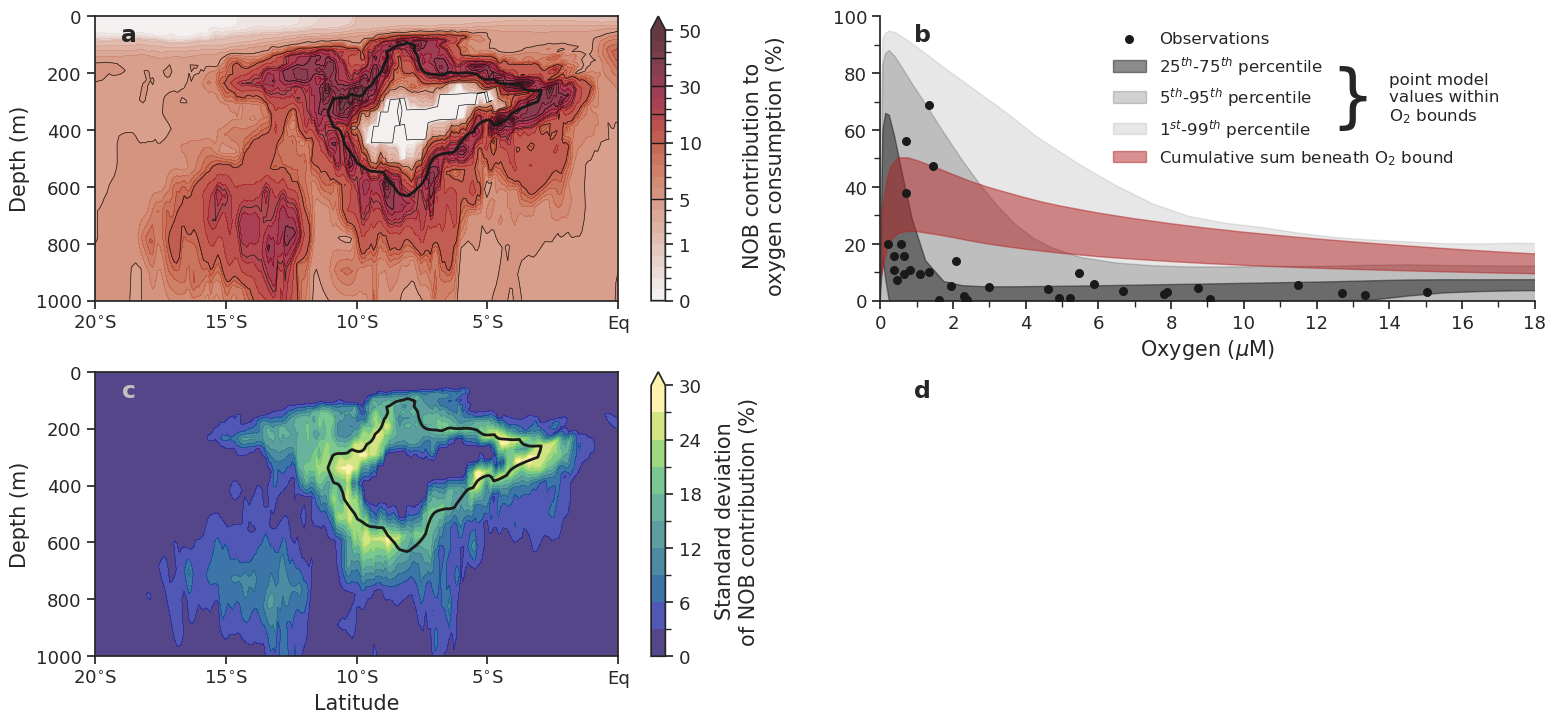

In [30]:

contcol = 'k' 

fstic = 13
fslab = 15

colmap1 = lighten(cmo.amp, 0.8)
levs1 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,51,4)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [0, 5, 10, 20, 30, 40]
contl1 = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


colmap2 = lighten(cmo.haline, 0.8)
levs2 = np.arange(0,31,3)
norm2 = mpl.colors.BoundaryNorm(levs2, colmap2.N)

fig = plt.figure(facecolor='w', figsize=(16,8))
gs = GridSpec(2,2)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic)
ax3.tick_params(labelsize=fstic)
ax4.tick_params(labelbottom=False, bottom=False, left=False, labelleft=False, right=False, labelright=False, top=False, labeltop=False)
ax2.spines[['top','right']].set_visible(False)
ax4.spines[['top','right','left','bottom']].set_visible(False)

norm_ytransect_o2nob = norm_ytransect_nox * (12.9/27.8) / norm_ytransect_o2cons * 100
norm_ytransect_o2nobmax = norm_ytransect_noxmax * (12.9/27.8) / norm_ytransect_o2consmax * 100
#ds['norm_o2nob'] = ds['norm_nitrox']*(12.9/27.8) / ds['norm_o2cons']*100


p1 = ax1.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nobmax.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c1 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nobmax.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c1o2 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

''' 
VERSION with different colours for the sensitivity experiments

### plot the model 5th, 25th, 50th, 75th and 95th quantiles of NOB contrib to O2 consumption
ax2.scatter(beman['O2'], beman['Nox_consump'], color='k', marker='o', alpha=1.0, s=30, zorder=3, label='Observations')
ax2.fill_between(oxylevs, norm_o2nob_amz_25, norm_o2nob_amz_75, color='k', alpha=0.5, label="25$^{th}$-75$^{th}$ percentile")
ax2.fill_between(oxylevs, norm_o2nob_amz_05, norm_o2nob_amz_95, color='k', alpha=0.2, label="5$^{th}$-95$^{th}$ percentile")
ax2.fill_between(oxylevs, norm_o2nob_amz_01, norm_o2nob_amz_99, color='k', alpha=0.1, label="1$^{st}$-99$^{th}$ percentile")
ax2.plot(amz_threshold, int_o2nob_mean, color='firebrick', linewidth=3.0, linestyle='-', label=r'$\mu^{max}_{NOB}$ = 2 $\times$ $\mu^{max}_{Het}$'+'\n(default)')
ax2.plot(amz_threshold, het2_o2nob_mean, color='goldenrod', linewidth=3.0, linestyle='-', label=r'$\mu^{max}_{NOB}$ = $\mu^{max}_{Het}$')
ax2.plot(amz_threshold, nob1_o2nob_mean, color='royalblue', linewidth=3.0, linestyle='-', label=r'$\mu^{max}_{NOB}$ = 0.5 $\times$ $\mu^{max}_{Het}$')
#ax2.fill_between(amz_threshold, int_o2nob_mean-int_o2nob_std, int_o2nob_mean+int_o2nob_std, color='firebrick', alpha=0.5)
ax2.fill_between(amz_threshold, int_o2nob_q01, int_o2nob_q99, color='firebrick', alpha=0.5)
ax2.fill_between(amz_threshold, het2_o2nob_q01, het2_o2nob_q99, color='goldenrod', alpha=0.5)
ax2.fill_between(amz_threshold, nob1_o2nob_q01, nob1_o2nob_q99, color='royalblue', alpha=0.5)

ax2.legend(loc='upper right', frameon=False, ncols=2, fontsize=fstic-1)
#ax2.text(12.75,71, "}", fontsize=50, ha='center', va='center', transform=ax2.transData)
#ax2.text(13.75,71, "default model\nvalues within\nO$_2$ bounds", fontsize=fstic-1, ha='left', va='center', transform=ax2.transData)

ax2.text(6,100, "Point values", fontsize=fslab, fontweight='bold', ha='left', va='bottom', transform=ax2.transData)
ax2.text(12,100, "Cumulative sum", fontsize=fslab, fontweight='bold', ha='left', va='bottom', transform=ax2.transData)
'''

'''
VERSION with different colours for the sensitivity experiments
'''
### plot the model 5th, 25th, 50th, 75th and 95th quantiles of NOB contrib to O2 consumption
ax2.scatter(beman['O2'], beman['Nox_consump'], color='k', marker='o', alpha=1.0, s=30, zorder=3, label='Observations')
ax2.fill_between(oxylevs, norm_o2nob_amz_25, norm_o2nob_amz_75, color='k', alpha=0.5, label="25$^{th}$-75$^{th}$ percentile")
ax2.fill_between(oxylevs, norm_o2nob_amz_05, norm_o2nob_amz_95, color='k', alpha=0.2, label="5$^{th}$-95$^{th}$ percentile")
ax2.fill_between(oxylevs, norm_o2nob_amz_01, norm_o2nob_amz_99, color='k', alpha=0.1, label="1$^{st}$-99$^{th}$ percentile")
ax2.fill_between(amz_threshold, nob1_o2nob_min, int_o2nob_max, color='firebrick', alpha=0.5, label='Cumulative sum beneath O$_2$ bound')

ax2.legend(loc='upper right', frameon=False, ncols=1, fontsize=fstic-1, bbox_to_anchor=(0.9,1.0))
ax2.text(13,71, "}", fontsize=50, ha='center', va='center', transform=ax2.transData)
ax2.text(14,71, "point model\nvalues within\nO$_2$ bounds", fontsize=fstic-1, ha='left', va='center', transform=ax2.transData)



p3 = ax3.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.std(dim='time'), \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c3o2 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


cb1 = plt.colorbar(p1, ax=ax1, ticks=levs1[[0,5,9,14,19,-1]])
cb1.ax.tick_params(labelsize=fstic)
cb1.ax.set_ylabel("NOB contribution to\noxygen consumption (%)", fontsize=fslab, labelpad=30)

cb3 = plt.colorbar(p3, ax=ax3)#, ticks=levs1[[0,5,10,14,18]])
cb3.ax.tick_params(labelsize=fstic)
cb3.ax.set_ylabel("Standard deviation\nof NOB contribution (%)", fontsize=fslab, labelpad=10)


x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)

x1 = 0; x2 = 18
y1 = 0; y2 = 100
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(10))

plt.subplots_adjust(top=0.95, left=0.075, right=0.975, bottom=0.15, hspace=0.25)


ax1.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax1.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','15$^{\circ}$S','10$^{\circ}$S','5$^{\circ}$S','Eq'])
ax3.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax3.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','15$^{\circ}$S','10$^{\circ}$S','5$^{\circ}$S','Eq'])

ax1.set_ylabel("Depth (m)", fontsize=fslab)
#ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Oxygen ($\mu$M)", fontsize=fslab)
ax3.set_ylabel("Depth (m)", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)

### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes)
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes, color='silver')
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)

#ax1.clabel(c1, manual=True, fontsize=fstic)

cb1.ax.hlines(conts1,0,1,color='k', linewidth=1)


In [31]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig4_nosensexps.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig4_nosensexps.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/fig4_nosensexps_transparent.png", dpi=300, transparent=True)


In [ ]:
#%% first make supplementary figure of NOB contribution to O2 consumption

contcol = 'k' 

fstic = 13
fslab = 15

colmap1 = lighten(cmo.oxy, 0.8)
levs1 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,101,10)))
norm1 = mpl.colors.BoundaryNorm(levs1, colmap1.N)
conts1 = [1, 5, 10, 50, 100]
contl1 = [0.5, 0.5, 0.5, 0.5, 0.5]

colmap2 = lighten(cmo.amp, 0.8)
levs2 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,101,10)))
norm2 = mpl.colors.BoundaryNorm(levs2, colmap2.N)
conts2 = [1, 5, 25, 50, 100]
contl2 = [0.5, 0.5, 0.5, 0.5, 0.5]

colmap3 = lighten(cmo.amp, 0.8)
levs3 = np.concatenate((np.arange(0,10,2)*0.1, np.arange(1,10,1), np.arange(10,51,5)))
norm3 = mpl.colors.BoundaryNorm(levs3, colmap3.N)
conts3 = [1, 5, 10, 25, 50]
contl3 = [0.5, 0.5, 0.5, 0.5, 0.5]



In [ ]:

fig = plt.figure(facecolor='w', figsize=(20,11))
gs = GridSpec(2,4)

ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[0,3])
ax5 = plt.subplot(gs[1,0])
ax6 = plt.subplot(gs[1,1])
ax7 = plt.subplot(gs[1,2])
ax8 = plt.subplot(gs[1,3])

   
p1 = ax1.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c1 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=conts1, colors=contcol, linewidths=contl1)
c1o2 = ax1.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p2 = ax2.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2cons.mean(dim='time')*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c2o2 = ax2.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

norm_ytransect_o2nob = norm_ytransect_nox * (12.9/27.8) / norm_ytransect_o2cons * 100
norm_ytransect_o2aoa = norm_ytransect_nhx * (15.5/11.0) / norm_ytransect_o2cons * 100

p3 = ax3.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c3 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2nob.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c3o2 = ax3.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)

p4 = ax4.contourf(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                  vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c4 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2aoa.mean(dim='time'), \
                 levels=conts3, colors=contcol, linewidths=contl3)
c4o2 = ax4.contour(norm_ytransect_y, norm_ytransect_z.mean(dim='time').values, norm_ytransect_o2.mean(dim='time'), \
                 levels=[1], colors=contcol, linewidths=2)


p5 = ax5.contourf(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                  vmin=levs1[0], vmax=levs1[-1], cmap=colmap1, norm=norm1, levels=levs1, extend='max')
c5 = ax5.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=conts1, colors=contcol, linewidths=contl1)
c5o2 = ax5.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=[1], colors=contcol, linewidths=2)

p6 = ax6.contourf(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2cons.mean(dim='time').values[:,0:314]*86400*1e3, \
                  vmin=levs2[0], vmax=levs2[-1], cmap=colmap2, norm=norm2, levels=levs2, extend='max')
c6 = ax6.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2cons.mean(dim='time').values[:,0:314]*86400*1e3, \
                 levels=conts2, colors=contcol, linewidths=contl2)
c6o2 = ax6.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=[1], colors=contcol, linewidths=2)

norm_xtransect_o2nob = norm_xtransect_nox * (12.9/27.8) / norm_xtransect_o2cons * 100
norm_xtransect_o2aoa = norm_xtransect_nhx * (15.5/11.0) / norm_xtransect_o2cons * 100

p7 = ax7.contourf(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2nob.mean(dim='time').values[:,0:314], \
                 vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c7 = ax7.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2nob.mean(dim='time').values[:,0:314], \
                 levels=conts3, colors=contcol, linewidths=contl3)
c7o2 = ax7.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=[1], colors=contcol, linewidths=2)

p8 = ax8.contourf(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2aoa.mean(dim='time').values[:,0:314], \
                 vmin=levs3[0], vmax=levs3[-1], cmap=colmap3, norm=norm3, levels=levs3, extend='max')
c8 = ax8.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2aoa.mean(dim='time').values[:,0:314], \
                 levels=conts3, colors=contcol, linewidths=contl3)
c8o2 = ax8.contour(norm_xtransect_x[:,0:314], norm_xtransect_z.mean(dim='time').values[:,0:314], norm_xtransect_o2.mean(dim='time').values[:,0:314], \
                 levels=[1], colors=contcol, linewidths=2)

cb1 = plt.colorbar(p1, ax=ax1, ticks=levs1[[0,5,9,14,18,23]])
cb2 = plt.colorbar(p2, ax=ax2, ticks=levs2[[0,5,9,14,18,23]])
cb3 = plt.colorbar(p3, ax=ax3, ticks=levs3[[0,5,9,14,17,22]])
cb4 = plt.colorbar(p4, ax=ax4, ticks=levs3[[0,5,9,14,17,22]])
cb5 = plt.colorbar(p5, ax=ax5, ticks=levs1[[0,5,9,14,18,23]])
cb6 = plt.colorbar(p6, ax=ax6, ticks=levs2[[0,5,9,14,18,23]])
cb7 = plt.colorbar(p7, ax=ax7, ticks=levs3[[0,5,9,14,17,22]])
cb8 = plt.colorbar(p8, ax=ax8, ticks=levs3[[0,5,9,14,17,22]])

cb1.ax.tick_params(labelsize=fstic)
cb2.ax.tick_params(labelsize=fstic)
cb3.ax.tick_params(labelsize=fstic)
cb4.ax.tick_params(labelsize=fstic)
cb5.ax.tick_params(labelsize=fstic)
cb6.ax.tick_params(labelsize=fstic)
cb7.ax.tick_params(labelsize=fstic)
cb8.ax.tick_params(labelsize=fstic)


x1 = -20; x2 = 0
y1 = -1000; y2 = 0
ax1.set_xlim(x1,x2)
ax1.set_ylim(y1,y2)
ax2.set_xlim(x1,x2)
ax2.set_ylim(y1,y2)
ax3.set_xlim(x1,x2)
ax3.set_ylim(y1,y2)
ax4.set_xlim(x1,x2)
ax4.set_ylim(y1,y2)
x1 = 255; x2 = 281
y1 = -1000; y2 = 0
ax5.set_xlim(x1,x2)
ax5.set_ylim(y1,y2)
ax6.set_xlim(x1,x2)
ax6.set_ylim(y1,y2)
ax7.set_xlim(x1,x2)
ax7.set_ylim(y1,y2)
ax8.set_xlim(x1,x2)
ax8.set_ylim(y1,y2)


ax1.tick_params(labelsize=fstic)
ax2.tick_params(labelsize=fstic, labelleft=False)
ax3.tick_params(labelsize=fstic, labelleft=False)
ax4.tick_params(labelsize=fstic, labelleft=False)
ax5.tick_params(labelsize=fstic)
ax6.tick_params(labelsize=fstic, labelleft=False)
ax7.tick_params(labelsize=fstic, labelleft=False)
ax8.tick_params(labelsize=fstic, labelleft=False)


plt.subplots_adjust(top=0.90, left=0.075, right=0.975, wspace=0.05, hspace=0.25, bottom=0.10)

ax1.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax1.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax2.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax3.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax4.set_xticks(np.arange(-20,1,5), ['20$^{\circ}$S','','10$^{\circ}$S','','Eq'])
ax5.set_yticks(np.arange(-1000,1,200), np.arange(-1000,1,200)*(-1))
ax5.set_xticks(np.arange(255,281,5), ['','260$^{\circ}$E',' ','270$^{\circ}$E','','280$^{\circ}$E'])
ax6.set_xticks(np.arange(255,281,5), ['','260$^{\circ}$E',' ','270$^{\circ}$E','','280$^{\circ}$E'])
ax7.set_xticks(np.arange(255,281,5), ['','260$^{\circ}$E',' ','270$^{\circ}$E','','280$^{\circ}$E'])
ax8.set_xticks(np.arange(255,281,5), ['','260$^{\circ}$E',' ','270$^{\circ}$E','','280$^{\circ}$E'])

ax1.set_ylabel("Depth (m)", fontsize=fslab)
ax1.set_xlabel("Latitude", fontsize=fslab)
ax2.set_xlabel("Latitude", fontsize=fslab)
ax3.set_xlabel("Latitude", fontsize=fslab)
ax4.set_xlabel("Latitude", fontsize=fslab)
ax5.set_ylabel("Depth (m)", fontsize=fslab)
ax5.set_xlabel("Longitude", fontsize=fslab)
ax6.set_xlabel("Longitude", fontsize=fslab)
ax7.set_xlabel("Longitude", fontsize=fslab)
ax8.set_xlabel("Longitude", fontsize=fslab)

ax1.set_title("oxygen ($\mu$M)", fontsize=fslab)
ax2.set_title("oxygen consumption (nM day$^{-1}$)", fontsize=fslab)
ax3.set_title("NOB contribution\nto oxygen consumption (%)", fontsize=fslab)
ax4.set_title("AOA contribution\nto oxygen consumption (%)", fontsize=fslab)


### add the letters
xx = 0.065; yy = 0.935
plt.text(xx,yy,'a', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax1.transAxes)
plt.text(xx,yy,'b', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax2.transAxes, color='silver')
plt.text(xx,yy,'c', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax3.transAxes)
plt.text(xx,yy,'d', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax4.transAxes)
plt.text(xx,yy,'e', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax5.transAxes)
plt.text(xx,yy,'f', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax6.transAxes, color='silver')
plt.text(xx,yy,'g', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax7.transAxes)
plt.text(xx,yy,'h', fontweight='bold', fontsize=fslab+2, va='center', ha='center', transform=ax8.transAxes)


In [ ]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig8.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig8.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig8_transparent.png", dpi=300, transparent=True)



# Plot O2 consumption along O2 concentration bins


In [ ]:
fig = plt.figure(facecolor='w', figsize=(10,6))
gs = GridSpec(1,1)

ax1 = plt.subplot(gs[0,0])

ax1.plot(oxylevs, norm_o2cons_amz_05, color='k', linewidth=2.0, linestyle=':')
ax1.plot(oxylevs, norm_o2cons_amz_25, color='k', linewidth=2.0, linestyle='--')
ax1.plot(oxylevs, norm_o2cons_amz_50, color='k', linewidth=2.0, linestyle='-')
ax1.plot(oxylevs, norm_o2cons_amz_75, color='k', linewidth=2.0, linestyle='--')
ax1.plot(oxylevs, norm_o2cons_amz_95, color='k', linewidth=2.0, linestyle=':')
#ax1.plot(oxylevs, oxylevs, color='firebrick', linewidth=1.0, linestyle='-')

#ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_xlim(0,2)
ax1.set_ylim(0,0.1)

ax1.set_xlabel("O$_2$ concentration ($\mu$M)", fontsize=fslab)
ax1.set_ylabel("O$_2$ consumption ($\mu$M day$^{-1}$)", fontsize=fslab)


In [ ]:
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig_o2consumption.png", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig_o2consumption.pdf", dpi=300)
fig.savefig("/home/pbuchanan/analysis_nox/figures/suppfig_o2consumption_transparent.png", dpi=300, transparent=True)
